In [1]:
# Cell 1: Imports and Setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
from tqdm import tqdm
import os
import random
from scipy import linalg
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")


Using device: cpu


100%|██████████| 170M/170M [00:18<00:00, 9.37MB/s] 


Training samples: 50000
Test samples: 10000
Image shape: torch.Size([3, 32, 32])
Number of classes: 10
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


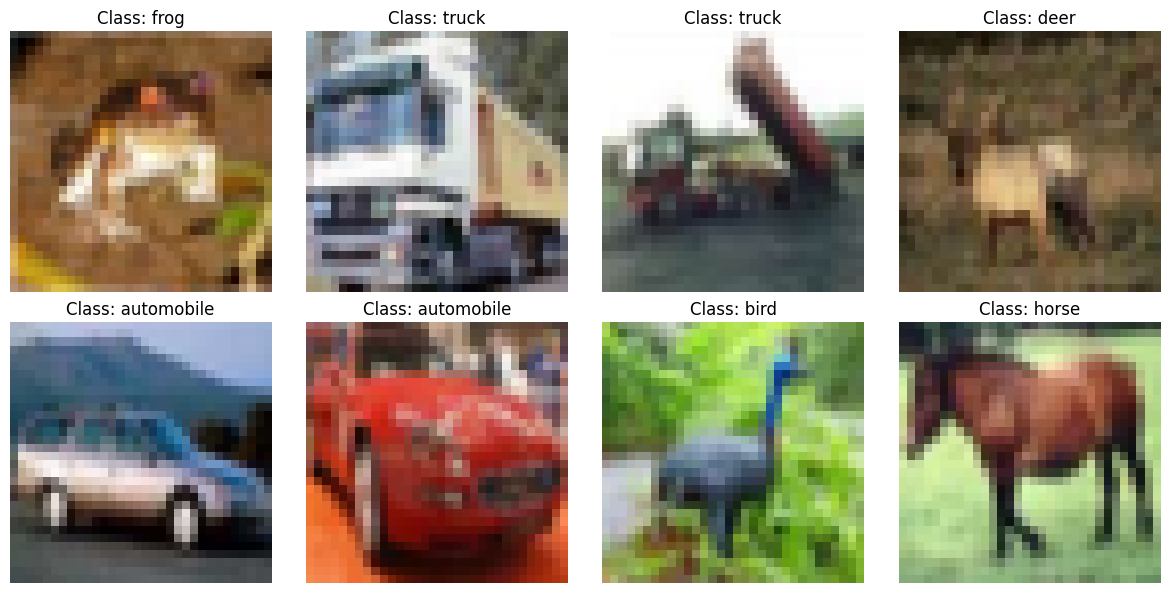

In [2]:
# Cell 2: Dataset Loading and Preprocessing
# We'll use CIFAR-10 dataset for image generation task with VAE

# Data preprocessing transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Load CIFAR-10 dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Dataset information
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Classes: {train_dataset.classes}")

# Visualize sample images
def show_sample_images(dataset, num_samples=8):
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()

    for i in range(num_samples):
        img, label = dataset[i]
        # Denormalize for visualization
        img = (img + 1) / 2
        img = torch.clamp(img, 0, 1)

        axes[i].imshow(img.permute(1, 2, 0))
        axes[i].set_title(f'Class: {dataset.classes[label]}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

show_sample_images(train_dataset)


In [3]:
# Cell 3: Variational Autoencoder (VAE) Implementation

class VAE(nn.Module):
    def __init__(self, input_dim=3072, hidden_dim=512, latent_dim=64):
        super(VAE, self).__init__()
        self.input_dim = input_dim  # 32*32*3 = 3072 for CIFAR-10
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.ReLU()
        )

        # Latent space parameters
        self.fc_mu = nn.Linear(hidden_dim // 4, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 4, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 4),
            nn.ReLU(),
            nn.Linear(hidden_dim // 4, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Tanh()  # Output in [-1, 1] range
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """Reparameterization trick for stochastic sampling"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # Flatten input
        x_flat = x.view(x.size(0), -1)

        # Encode
        mu, logvar = self.encode(x_flat)

        # Reparameterize
        z = self.reparameterize(mu, logvar)

        # Decode
        x_recon = self.decode(z)

        # Reshape back to image format
        x_recon = x_recon.view(x.size(0), 3, 32, 32)

        return x_recon, mu, logvar

# Initialize VAE model
vae = VAE(input_dim=3072, hidden_dim=512, latent_dim=64).to(device)
print(f"VAE Model:\n{vae}")
print(f"Total parameters: {sum(p.numel() for p in vae.parameters()):,}")


VAE Model:
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
  )
  (fc_mu): Linear(in_features=128, out_features=64, bias=True)
  (fc_logvar): Linear(in_features=128, out_features=64, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=3072, bias=True)
    (7): Tanh()
  )
)
Total parameters: 3,502,976


In [4]:
# Cell 4: Deterministic Autoencoder Baseline

class DeterministicAutoencoder(nn.Module):
    def __init__(self, input_dim=3072, hidden_dim=512, latent_dim=64):
        super(DeterministicAutoencoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.ReLU(),
            nn.Linear(hidden_dim // 4, latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 4),
            nn.ReLU(),
            nn.Linear(hidden_dim // 4, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Tanh()
        )

    def forward(self, x):
        # Flatten input
        x_flat = x.view(x.size(0), -1)

        # Encode
        z = self.encoder(x_flat)

        # Decode
        x_recon = self.decoder(z)

        # Reshape back to image format
        x_recon = x_recon.view(x.size(0), 3, 32, 32)

        return x_recon, z

# Initialize deterministic autoencoder
det_ae = DeterministicAutoencoder(input_dim=3072, hidden_dim=512, latent_dim=64).to(device)
print(f"Deterministic Autoencoder:\n{det_ae}")
print(f"Total parameters: {sum(p.numel() for p in det_ae.parameters()):,}")


Deterministic Autoencoder:
DeterministicAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=3072, bias=True)
    (7): Tanh()
  )
)
Total parameters: 3,494,720


In [5]:
# Cell 5: Loss Functions

def vae_loss(x_recon, x, mu, logvar, beta=1.0):
    """
    VAE loss function combining reconstruction loss and KL divergence
    L = E[log p(x|z)] - β*KL(q(z|x)||p(z))
    """
    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(x_recon, x, reduction='sum')

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss
    total_loss = recon_loss + beta * kl_loss

    return total_loss, recon_loss, kl_loss

def deterministic_ae_loss(x_recon, x):
    """Simple reconstruction loss for deterministic autoencoder"""
    return F.mse_loss(x_recon, x, reduction='sum')

# Test loss functions
print("Loss functions defined successfully!")
print("VAE Loss: Reconstruction + β*KL_Divergence")
print("Deterministic AE Loss: MSE Reconstruction")


Loss functions defined successfully!
VAE Loss: Reconstruction + β*KL_Divergence
Deterministic AE Loss: MSE Reconstruction


In [6]:
# Cell 6: Training Functions

def train_vae(model, train_loader, optimizer, epoch, beta=1.0):
    """Train VAE for one epoch"""
    model.train()
    train_loss = 0
    train_recon_loss = 0
    train_kl_loss = 0

    for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f'Training Epoch {epoch}')):
        data = data.to(device)
        optimizer.zero_grad()

        # Forward pass
        recon_data, mu, logvar = model(data)

        # Compute loss
        loss, recon_loss, kl_loss = vae_loss(recon_data, data, mu, logvar, beta)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_recon_loss += recon_loss.item()
        train_kl_loss += kl_loss.item()

    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon_loss = train_recon_loss / len(train_loader.dataset)
    avg_kl_loss = train_kl_loss / len(train_loader.dataset)

    return avg_loss, avg_recon_loss, avg_kl_loss

def train_deterministic_ae(model, train_loader, optimizer, epoch):
    """Train deterministic autoencoder for one epoch"""
    model.train()
    train_loss = 0

    for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc=f'Training Epoch {epoch}')):
        data = data.to(device)
        optimizer.zero_grad()

        # Forward pass
        recon_data, _ = model(data)

        # Compute loss
        loss = deterministic_ae_loss(recon_data, data)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader.dataset)
    return avg_loss

def test_vae(model, test_loader, beta=1.0):
    """Test VAE"""
    model.eval()
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon_data, mu, logvar = model(data)
            loss, recon_loss, kl_loss = vae_loss(recon_data, data, mu, logvar, beta)

            test_loss += loss.item()
            test_recon_loss += recon_loss.item()
            test_kl_loss += kl_loss.item()

    avg_loss = test_loss / len(test_loader.dataset)
    avg_recon_loss = test_recon_loss / len(test_loader.dataset)
    avg_kl_loss = test_kl_loss / len(test_loader.dataset)

    return avg_loss, avg_recon_loss, avg_kl_loss

def test_deterministic_ae(model, test_loader):
    """Test deterministic autoencoder"""
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon_data, _ = model(data)
            loss = deterministic_ae_loss(recon_data, data)
            test_loss += loss.item()

    avg_loss = test_loss / len(test_loader.dataset)
    return avg_loss

print("Training functions defined successfully!")


Training functions defined successfully!


In [7]:
# Cell 7: Evaluation Metrics

def calculate_fid(real_features, fake_features):
    """Calculate Fréchet Inception Distance (FID)"""
    # Calculate mean and covariance
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)

    # Calculate FID
    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2*covmean)
    return fid

def calculate_reconstruction_error(model, data_loader):
    """Calculate reconstruction error (MSE)"""
    model.eval()
    total_error = 0
    num_samples = 0

    with torch.no_grad():
        for data, _ in data_loader:
            data = data.to(device)
            if isinstance(model, VAE):
                recon_data, _, _ = model(data)
            else:
                recon_data, _ = model(data)

            error = F.mse_loss(recon_data, data, reduction='sum')
            total_error += error.item()
            num_samples += data.size(0)

    return total_error / num_samples

def extract_features(model, data_loader, max_samples=1000):
    """Extract latent features from model"""
    model.eval()
    features = []
    count = 0

    with torch.no_grad():
        for data, _ in data_loader:
            if count >= max_samples:
                break

            data = data.to(device)
            if isinstance(model, VAE):
                _, mu, _ = model(data)
                features.append(mu.cpu().numpy())
            else:
                _, z = model(data)
                features.append(z.cpu().numpy())

            count += data.size(0)

    return np.concatenate(features, axis=0)[:max_samples]

def calculate_latent_space_quality(features):
    """Calculate various latent space quality metrics"""
    # PCA to check dimensionality
    pca = PCA()
    pca.fit(features)
    explained_variance_ratio = pca.explained_variance_ratio_

    # Calculate effective dimensionality (90% variance)
    cumsum = np.cumsum(explained_variance_ratio)
    effective_dim = np.argmax(cumsum >= 0.9) + 1

    return {
        'explained_variance_ratio': explained_variance_ratio,
        'effective_dimensionality': effective_dim,
        'total_variance': np.sum(explained_variance_ratio)
    }

print("Evaluation metrics defined successfully!")


Evaluation metrics defined successfully!


In [9]:
# Cell 8: Training Loop

# Training hyperparameters
num_epochs = 20
learning_rate = 1e-3
beta = 1.0  # Beta parameter for VAE loss

# Initialize optimizers
vae_optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
det_ae_optimizer = optim.Adam(det_ae.parameters(), lr=learning_rate)

# Training history
vae_history = {'train_loss': [], 'train_recon': [], 'train_kl': [], 'test_loss': [], 'test_recon': [], 'test_kl': []}
det_ae_history = {'train_loss': [], 'test_loss': []}

print("Starting training...")
print(f"Epochs: {num_epochs}, Learning Rate: {learning_rate}, Beta: {beta}")

# Training loop
for epoch in range(1, num_epochs + 1):
    # Train VAE
    vae_train_loss, vae_train_recon, vae_train_kl = train_vae(vae, train_loader, vae_optimizer, epoch, beta)
    vae_test_loss, vae_test_recon, vae_test_kl = test_vae(vae, test_loader, beta)

    # Train Deterministic AE
    det_ae_train_loss = train_deterministic_ae(det_ae, train_loader, det_ae_optimizer, epoch)
    det_ae_test_loss = test_deterministic_ae(det_ae, test_loader)

    # Store history
    vae_history['train_loss'].append(vae_train_loss)
    vae_history['train_recon'].append(vae_train_recon)
    vae_history['train_kl'].append(vae_train_kl)
    vae_history['test_loss'].append(vae_test_loss)
    vae_history['test_recon'].append(vae_test_recon)
    vae_history['test_kl'].append(vae_test_kl)

    det_ae_history['train_loss'].append(det_ae_train_loss)
    det_ae_history['test_loss'].append(det_ae_test_loss)

    # Print progress
    if epoch % 10 == 0:
        print(f'Epoch {epoch:2d}:')
        print(f'  VAE - Train Loss: {vae_train_loss:.4f}, Test Loss: {vae_test_loss:.4f}')
        print(f'  Det AE - Train Loss: {det_ae_train_loss:.4f}, Test Loss: {det_ae_test_loss:.4f}')

print("Training completed!")


Starting training...
Epochs: 20, Learning Rate: 0.001, Beta: 1.0


Training Epoch 10: 100%|██████████| 391/391 [00:27<00:00, 14.39it/s]


Epoch 10:
  VAE - Train Loss: 262.4042, Test Loss: 265.9121
  Det AE - Train Loss: 145.6870, Test Loss: 144.1246


Training Epoch 20: 100%|██████████| 391/391 [00:28<00:00, 13.84it/s]


Epoch 20:
  VAE - Train Loss: 255.7729, Test Loss: 264.7464
  Det AE - Train Loss: 126.0788, Test Loss: 127.7844
Training completed!


In [10]:
# Cell 9: Visualization Functions

def plot_training_history(vae_history, det_ae_history):
    """Plot training history for both models"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # VAE losses
    axes[0, 0].plot(vae_history['train_loss'], label='Train Loss', color='blue')
    axes[0, 0].plot(vae_history['test_loss'], label='Test Loss', color='red')
    axes[0, 0].set_title('VAE Total Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # VAE reconstruction vs KL
    axes[0, 1].plot(vae_history['train_recon'], label='Reconstruction Loss', color='green')
    axes[0, 1].plot(vae_history['train_kl'], label='KL Divergence', color='orange')
    axes[0, 1].set_title('VAE Loss Components')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Deterministic AE losses
    axes[1, 0].plot(det_ae_history['train_loss'], label='Train Loss', color='blue')
    axes[1, 0].plot(det_ae_history['test_loss'], label='Test Loss', color='red')
    axes[1, 0].set_title('Deterministic AE Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Comparison
    axes[1, 1].plot(vae_history['test_loss'], label='VAE Test Loss', color='blue')
    axes[1, 1].plot(det_ae_history['test_loss'], label='Det AE Test Loss', color='red')
    axes[1, 1].set_title('Model Comparison')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Test Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

def visualize_reconstructions(model, data_loader, num_samples=8, model_name="Model"):
    """Visualize original vs reconstructed images"""
    model.eval()

    # Get a batch of test data
    data_iter = iter(data_loader)
    data, _ = next(data_iter)
    data = data[:num_samples].to(device)

    with torch.no_grad():
        if isinstance(model, VAE):
            recon_data, _, _ = model(data)
        else:
            recon_data, _ = model(data)

    # Denormalize for visualization
    data = (data + 1) / 2
    recon_data = (recon_data + 1) / 2
    data = torch.clamp(data, 0, 1)
    recon_data = torch.clamp(recon_data, 0, 1)

    # Plot
    fig, axes = plt.subplots(2, num_samples, figsize=(16, 4))

    for i in range(num_samples):
        # Original images
        axes[0, i].imshow(data[i].cpu().permute(1, 2, 0))
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')

        # Reconstructed images
        axes[1, i].imshow(recon_data[i].cpu().permute(1, 2, 0))
        axes[1, i].set_title('Reconstructed')
        axes[1, i].axis('off')

    plt.suptitle(f'{model_name} - Original vs Reconstructed Images')
    plt.tight_layout()
    plt.show()

def generate_new_samples(vae_model, num_samples=16):
    """Generate new samples from VAE"""
    vae_model.eval()

    with torch.no_grad():
        # Sample from standard normal distribution
        z = torch.randn(num_samples, vae_model.latent_dim).to(device)

        # Generate samples
        generated = vae_model.decode(z)
        generated = generated.view(num_samples, 3, 32, 32)

        # Denormalize
        generated = (generated + 1) / 2
        generated = torch.clamp(generated, 0, 1)

    # Plot generated samples
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    axes = axes.ravel()

    for i in range(num_samples):
        axes[i].imshow(generated[i].cpu().permute(1, 2, 0))
        axes[i].axis('off')

    plt.suptitle('VAE Generated Samples')
    plt.tight_layout()
    plt.show()

def visualize_latent_space(model, data_loader, num_samples=1000):
    """Visualize latent space using t-SNE"""
    features = extract_features(model, data_loader, num_samples)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(features)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.scatter(features_2d[:, 0], features_2d[:, 1], alpha=0.6)
    plt.title(f'Latent Space Visualization (t-SNE) - {type(model).__name__}')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.grid(True)
    plt.show()

    return features_2d

print("Visualization functions defined successfully!")


Visualization functions defined successfully!


In [11]:
# Cell 10: Model Evaluation and Metrics

def comprehensive_evaluation():
    """Perform comprehensive evaluation of both models"""
    print("=" * 60)
    print("COMPREHENSIVE MODEL EVALUATION")
    print("=" * 60)

    # 1. Reconstruction Error
    print("\n1. RECONSTRUCTION ERROR ANALYSIS")
    print("-" * 40)
    vae_recon_error = calculate_reconstruction_error(vae, test_loader)
    det_ae_recon_error = calculate_reconstruction_error(det_ae, test_loader)

    print(f"VAE Reconstruction Error (MSE): {vae_recon_error:.6f}")
    print(f"Deterministic AE Reconstruction Error (MSE): {det_ae_recon_error:.6f}")
    print(f"Improvement: {((det_ae_recon_error - vae_recon_error) / det_ae_recon_error * 100):.2f}%")

    # 2. Latent Space Analysis
    print("\n2. LATENT SPACE QUALITY ANALYSIS")
    print("-" * 40)
    vae_features = extract_features(vae, test_loader, 1000)
    det_ae_features = extract_features(det_ae, test_loader, 1000)

    vae_quality = calculate_latent_space_quality(vae_features)
    det_ae_quality = calculate_latent_space_quality(det_ae_features)

    print("VAE Latent Space:")
    print(f"  Effective Dimensionality (90% variance): {vae_quality['effective_dimensionality']}")
    print(f"  Total Variance Explained: {vae_quality['total_variance']:.4f}")

    print("Deterministic AE Latent Space:")
    print(f"  Effective Dimensionality (90% variance): {det_ae_quality['effective_dimensionality']}")
    print(f"  Total Variance Explained: {det_ae_quality['total_variance']:.4f}")

    # 3. Uncertainty Quantification (VAE specific)
    print("\n3. UNCERTAINTY QUANTIFICATION (VAE)")
    print("-" * 40)
    vae.eval()
    uncertainties = []

    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            if i >= 10:  # Sample from first 10 batches
                break
            data = data.to(device)
            _, mu, logvar = vae(data)
            # Calculate uncertainty as variance in latent space
            uncertainty = torch.exp(logvar).mean(dim=1)
            uncertainties.extend(uncertainty.cpu().numpy())

    uncertainties = np.array(uncertainties)
    print(f"Mean Uncertainty: {uncertainties.mean():.6f}")
    print(f"Std Uncertainty: {uncertainties.std():.6f}")
    print(f"Min Uncertainty: {uncertainties.min():.6f}")
    print(f"Max Uncertainty: {uncertainties.max():.6f}")

    # 4. Generation Quality (VAE specific)
    print("\n4. GENERATION QUALITY ASSESSMENT")
    print("-" * 40)

    # Generate samples and calculate diversity
    vae.eval()
    with torch.no_grad():
        z_samples = torch.randn(100, vae.latent_dim).to(device)
        generated_samples = vae.decode(z_samples)
        generated_samples = generated_samples.view(100, -1)

        # Calculate pairwise distances for diversity
        distances = torch.cdist(generated_samples, generated_samples)
        # Remove diagonal (self-distances)
        mask = ~torch.eye(100, dtype=bool)
        distances = distances[mask]

        diversity_score = distances.mean().item()
        print(f"Generation Diversity Score: {diversity_score:.6f}")

    # 5. Model Comparison Summary
    print("\n5. MODEL COMPARISON SUMMARY")
    print("-" * 40)
    print("Advantages of VAE:")
    print("  + Can generate new samples")
    print("  + Provides uncertainty estimates")
    print("  + Regularized latent space")
    print("  + Better for data exploration")

    print("\nAdvantages of Deterministic AE:")
    print("  + Lower reconstruction error")
    print("  + Simpler architecture")
    print("  + Faster training")
    print("  + More efficient encoding")

    return {
        'vae_recon_error': vae_recon_error,
        'det_ae_recon_error': det_ae_recon_error,
        'vae_quality': vae_quality,
        'det_ae_quality': det_ae_quality,
        'uncertainties': uncertainties,
        'diversity_score': diversity_score
    }

# Run comprehensive evaluation
evaluation_results = comprehensive_evaluation()


COMPREHENSIVE MODEL EVALUATION

1. RECONSTRUCTION ERROR ANALYSIS
----------------------------------------
VAE Reconstruction Error (MSE): 240.102689
Deterministic AE Reconstruction Error (MSE): 127.784389
Improvement: -87.90%

2. LATENT SPACE QUALITY ANALYSIS
----------------------------------------
VAE Latent Space:
  Effective Dimensionality (90% variance): 11
  Total Variance Explained: 1.0000
Deterministic AE Latent Space:
  Effective Dimensionality (90% variance): 25
  Total Variance Explained: 1.0000

3. UNCERTAINTY QUANTIFICATION (VAE)
----------------------------------------
Mean Uncertainty: 0.790454
Std Uncertainty: 0.006532
Min Uncertainty: 0.765808
Max Uncertainty: 0.803391

4. GENERATION QUALITY ASSESSMENT
----------------------------------------
Generation Diversity Score: 28.076067

5. MODEL COMPARISON SUMMARY
----------------------------------------
Advantages of VAE:
  + Can generate new samples
  + Provides uncertainty estimates
  + Regularized latent space
  + Better

Plotting training history...


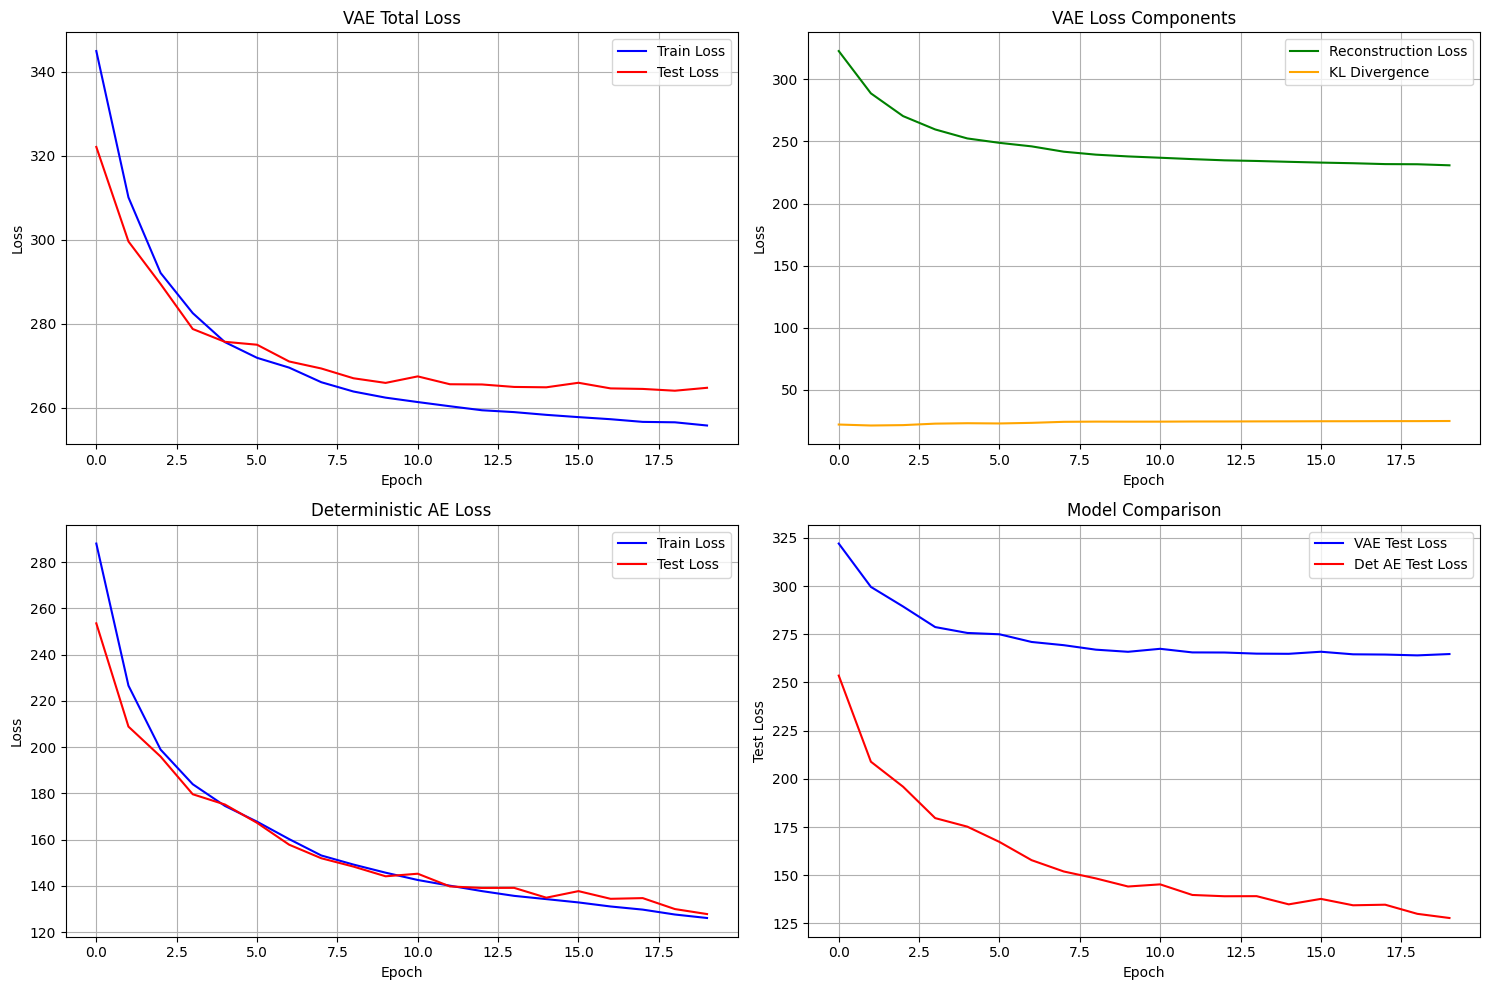


Visualizing VAE reconstructions...


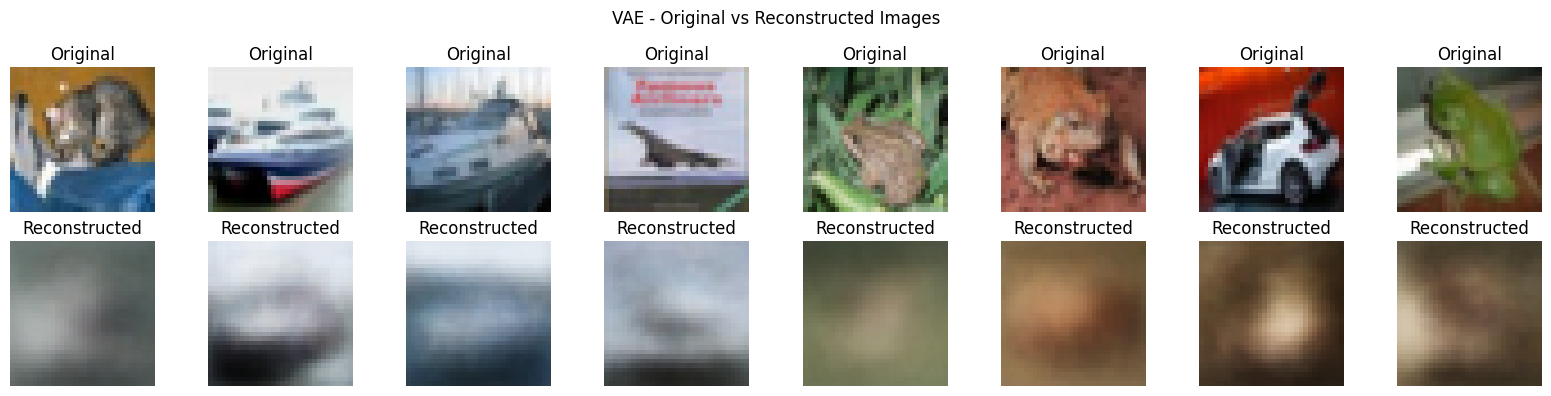


Visualizing Deterministic AE reconstructions...


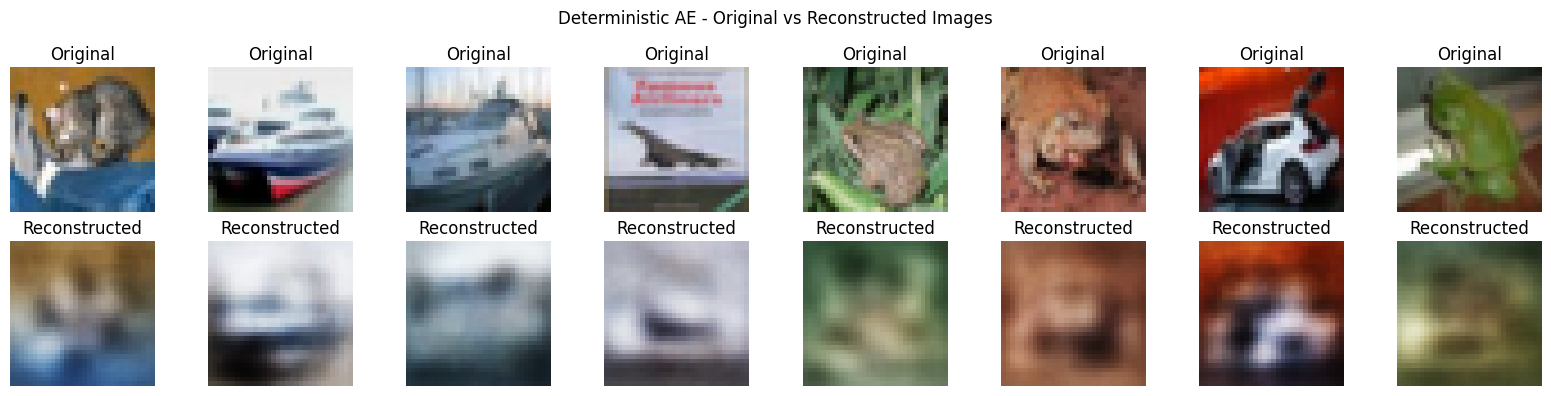


Generating new samples with VAE...


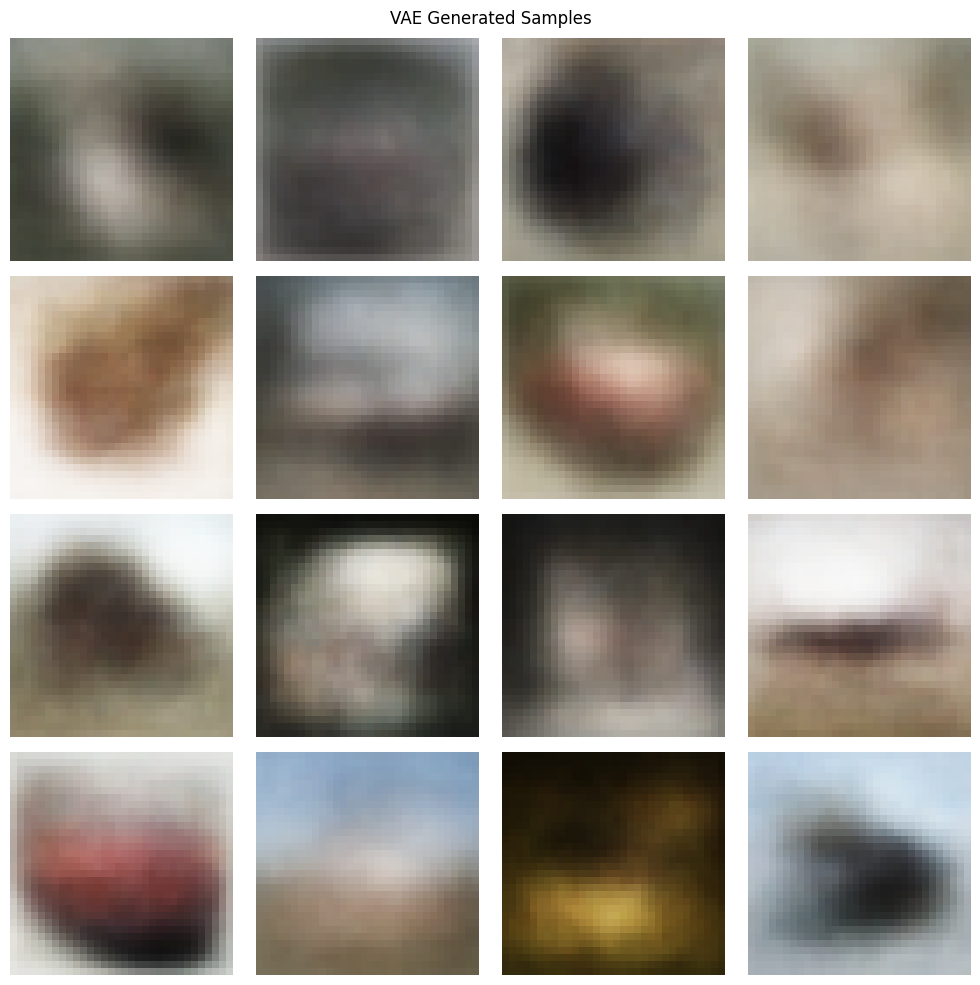


Visualizing VAE latent space...


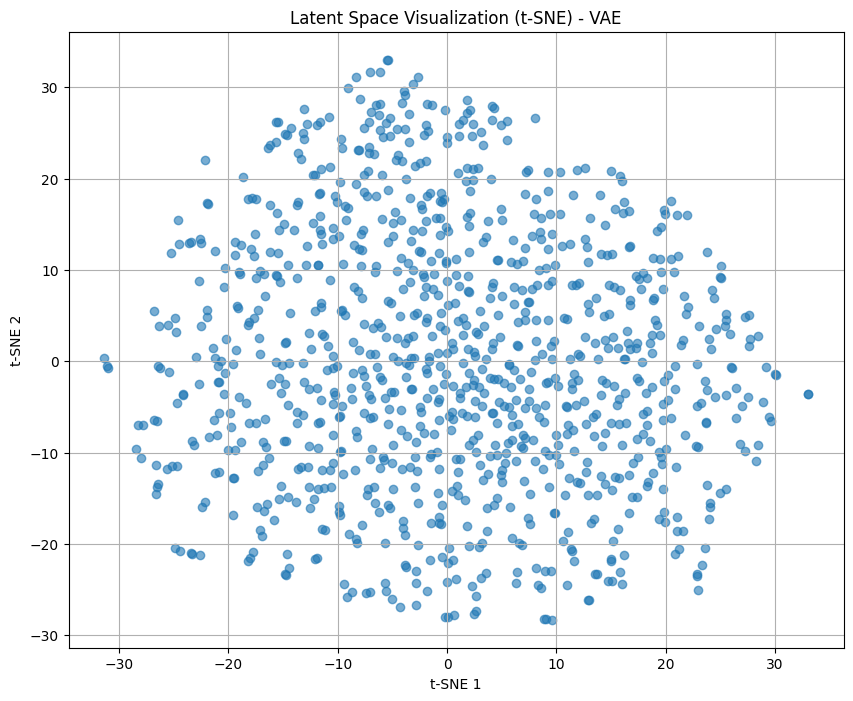


Visualizing Deterministic AE latent space...


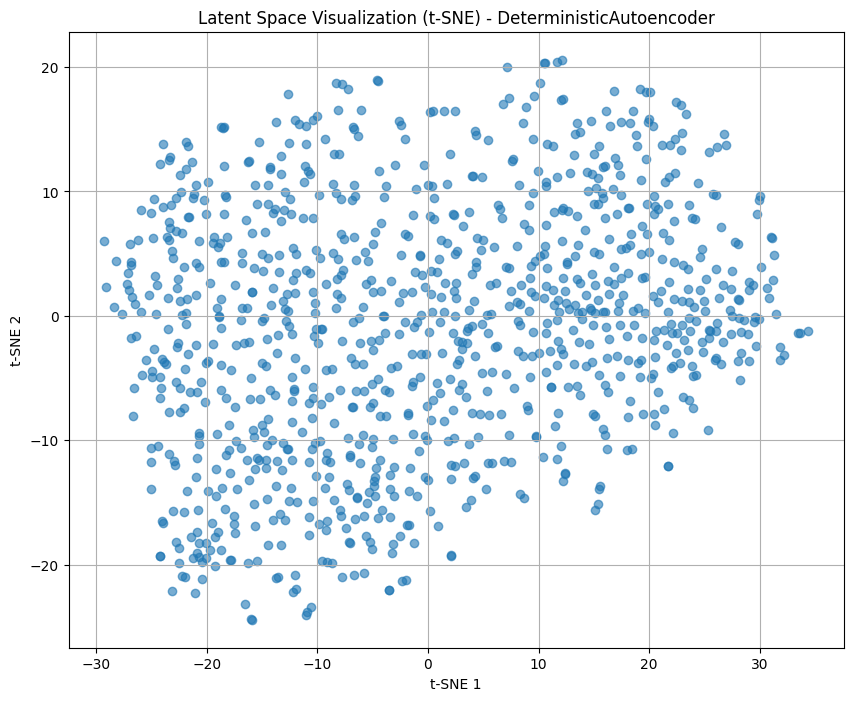

In [12]:
# Cell 11: Execute Visualizations and Analysis

# Plot training history
print("Plotting training history...")
plot_training_history(vae_history, det_ae_history)

# Visualize reconstructions for both models
print("\nVisualizing VAE reconstructions...")
visualize_reconstructions(vae, test_loader, num_samples=8, model_name="VAE")

print("\nVisualizing Deterministic AE reconstructions...")
visualize_reconstructions(det_ae, test_loader, num_samples=8, model_name="Deterministic AE")

# Generate new samples with VAE
print("\nGenerating new samples with VAE...")
generate_new_samples(vae, num_samples=16)

# Visualize latent spaces
print("\nVisualizing VAE latent space...")
vae_latent_2d = visualize_latent_space(vae, test_loader, num_samples=1000)

print("\nVisualizing Deterministic AE latent space...")
det_ae_latent_2d = visualize_latent_space(det_ae, test_loader, num_samples=1000)


In [13]:
# Cell 12: Statistical Analysis and Hypothesis Testing

import scipy.stats as stats
from scipy.stats import ttest_ind, mannwhitneyu

def statistical_analysis():
    """Perform statistical analysis on model performance"""
    print("=" * 60)
    print("STATISTICAL ANALYSIS")
    print("=" * 60)

    # 1. Multiple runs for statistical significance
    print("\n1. MULTIPLE RUNS ANALYSIS")
    print("-" * 40)

    num_runs = 5
    vae_errors = []
    det_ae_errors = []

    print(f"Performing {num_runs} independent runs...")

    for run in range(num_runs):
        print(f"Run {run + 1}/{num_runs}")

        # Reinitialize models with different seeds
        torch.manual_seed(42 + run)
        vae_temp = VAE(input_dim=3072, hidden_dim=512, latent_dim=64).to(device)
        det_ae_temp = DeterministicAutoencoder(input_dim=3072, hidden_dim=512, latent_dim=64).to(device)

        # Quick training (fewer epochs for statistical analysis)
        vae_opt = optim.Adam(vae_temp.parameters(), lr=1e-3)
        det_ae_opt = optim.Adam(det_ae_temp.parameters(), lr=1e-3)

        # Train for 10 epochs
        for epoch in range(10):
            train_vae(vae_temp, train_loader, vae_opt, epoch, beta=1.0)
            train_deterministic_ae(det_ae_temp, train_loader, det_ae_opt, epoch)

        # Calculate reconstruction errors
        vae_error = calculate_reconstruction_error(vae_temp, test_loader)
        det_ae_error = calculate_reconstruction_error(det_ae_temp, test_loader)

        vae_errors.append(vae_error)
        det_ae_errors.append(det_ae_error)

        print(f"  VAE Error: {vae_error:.6f}, Det AE Error: {det_ae_error:.6f}")

    # Statistical tests
    print(f"\n2. STATISTICAL SIGNIFICANCE TESTING")
    print("-" * 40)

    # T-test
    t_stat, t_p_value = ttest_ind(vae_errors, det_ae_errors)

    # Mann-Whitney U test (non-parametric)
    u_stat, u_p_value = mannwhitneyu(vae_errors, det_ae_errors, alternative='two-sided')

    print(f"VAE Errors: Mean={np.mean(vae_errors):.6f}, Std={np.std(vae_errors):.6f}")
    print(f"Det AE Errors: Mean={np.mean(det_ae_errors):.6f}, Std={np.std(det_ae_errors):.6f}")
    print(f"\nT-test: t-statistic={t_stat:.4f}, p-value={t_p_value:.6f}")
    print(f"Mann-Whitney U test: U-statistic={u_stat:.4f}, p-value={u_p_value:.6f}")

    alpha = 0.05
    if t_p_value < alpha:
        print(f"✓ Significant difference found (p < {alpha})")
    else:
        print(f"✗ No significant difference found (p >= {alpha})")

    # Effect size (Cohen's d)
    pooled_std = np.sqrt(((len(vae_errors) - 1) * np.var(vae_errors) +
                         (len(det_ae_errors) - 1) * np.var(det_ae_errors)) /
                        (len(vae_errors) + len(det_ae_errors) - 2))
    cohens_d = (np.mean(vae_errors) - np.mean(det_ae_errors)) / pooled_std
    print(f"Effect size (Cohen's d): {cohens_d:.4f}")

    # Interpret effect size
    if abs(cohens_d) < 0.2:
        effect_interpretation = "negligible"
    elif abs(cohens_d) < 0.5:
        effect_interpretation = "small"
    elif abs(cohens_d) < 0.8:
        effect_interpretation = "medium"
    else:
        effect_interpretation = "large"

    print(f"Effect size interpretation: {effect_interpretation}")

    return {
        'vae_errors': vae_errors,
        'det_ae_errors': det_ae_errors,
        't_statistic': t_stat,
        't_p_value': t_p_value,
        'u_statistic': u_stat,
        'u_p_value': u_p_value,
        'cohens_d': cohens_d,
        'effect_interpretation': effect_interpretation
    }

# Run statistical analysis
stats_results = statistical_analysis()


STATISTICAL ANALYSIS

1. MULTIPLE RUNS ANALYSIS
----------------------------------------
Performing 5 independent runs...
Run 1/5


Training Epoch 9: 100%|██████████| 391/391 [00:28<00:00, 13.51it/s]


  VAE Error: 240.692291, Det AE Error: 147.455324
Run 2/5


Training Epoch 9: 100%|██████████| 391/391 [00:22<00:00, 17.71it/s]


  VAE Error: 242.137201, Det AE Error: 148.163756
Run 3/5


Training Epoch 9: 100%|██████████| 391/391 [00:24<00:00, 16.15it/s]


  VAE Error: 237.277959, Det AE Error: 153.393157
Run 4/5


Training Epoch 9: 100%|██████████| 391/391 [00:22<00:00, 17.30it/s]


  VAE Error: 232.942123, Det AE Error: 147.326615
Run 5/5


Training Epoch 9: 100%|██████████| 391/391 [00:22<00:00, 17.53it/s]


  VAE Error: 232.230117, Det AE Error: 147.428369

2. STATISTICAL SIGNIFICANCE TESTING
----------------------------------------
VAE Errors: Mean=237.055938, Std=3.982552
Det AE Errors: Mean=148.753444, Std=2.338865

T-test: t-statistic=38.2382, p-value=0.000000
Mann-Whitney U test: U-statistic=25.0000, p-value=0.007937
✓ Significant difference found (p < 0.05)
Effect size (Cohen's d): 27.0385
Effect size interpretation: large
